## Modelos de Clasificación/Extracción

Este notebook cubre:
- Análisis exploratorio de los datos. 
- Distintas formas de extraer los vectores de cada canción.
- Modelos de clasificacion.

In [17]:
import librosa
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

DATASET_PATH = "/media/sebastian/Elements/Dataset"

## EDA
- Sup. en `/dataset` existe una carpeta para cada genero a clasificar con representantes del mismo.

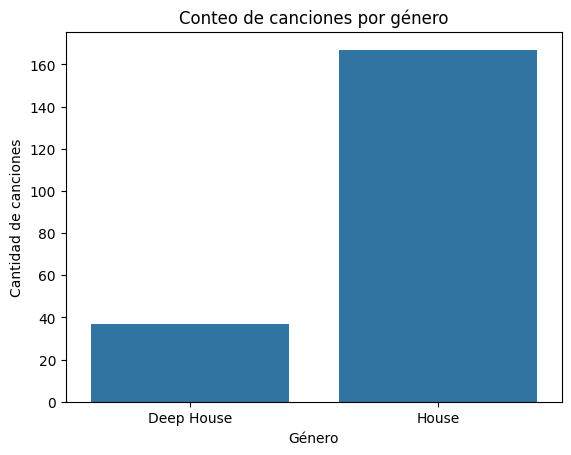

In [25]:
get_files_with_valid_extensions = lambda sourceDirectory, extensions:[
        file for file in os.listdir(sourceDirectory)
        if os.path.isfile(os.path.join(sourceDirectory, file)) and os.path.splitext(file)[1].lower() in extensions
    ]
list_dir = lambda aPath: os.listdir(aPath)

songs_in_dataset = {}
for genre in list_dir(DATASET_PATH):
    songs_in_dataset[genre] = get_files_with_valid_extensions(f"{DATASET_PATH}/{genre}", extensions=[".mp3",".wav"])

count = { genre:len(songs) for genre, songs in songs_in_dataset.items() }
ax = sns.barplot(count)
ax.set_title("Conteo de canciones por género")
ax.set_xlabel("Género")
ax.set_ylabel("Cantidad de canciones")
plt.show()

## Vectorización

En esta etapa extraemos la mayor cantidad de features posibles, luego analizamos con cuáles es útiles quedarnos, según cuáles aporten más información.

In [38]:
N_MFCC = 13

def vectorize_track(aTrackFilePath):
    """ versión copmpleta """
    y, sr = librosa.load(aTrackFilePath, sr=None)
    bpm = librosa.beat.beat_track(y=y, sr=sr)[0][0]
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC).mean(axis=1)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr).mean(axis=1)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean(axis=1)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()
    rms = librosa.feature.rms(y=y).mean()
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()
    features = [bpm, spectral_centroid] + list(mfcc) + list(chroma) + [spectral_bandwidth, spectral_contrast.mean(), zero_crossing_rate, rms, spectral_rolloff]
    return features

In [31]:
dataset = []
for genre_dir in list_dir(DATASET_PATH):
    for file in list_dir(DATASET_PATH+"/"+genre_dir)[:50]:
        features = vectorize_track(f"{DATASET_PATH}/{genre_dir}/{file}")
        features.insert(0, file)
        features.insert(0, genre_dir)
        dataset.append(features)

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 782781.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/tmp/ipykernel_71960/2144118787.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(aTrackFilePath, sr=None)
/home/sebastian/.local/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Note: Illegal Audio-MPEG-Header 0x16d27eed at offset 16554383.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/lib

In [93]:
# fix posterior
# dataset["genre"] = dataset["track"].apply(lambda track_name: "House" if track_name in songs_in_dataset["House"] else "Deep House")

In [94]:
headers = \
     ["track", "genre", "bpm", "spectral_centroid"] + \
     [f"mfcc_{i}" for i in range(N_MFCC)] + \
     [f"chroma_{i}" for i in range(12)] + \
     ["spectral_bandwidth", "spectral_contrast_mean", "zero_crossing_rate", "rms", "spectral_rolloff"]

In [95]:
dataset = pd.DataFrame(dataset, columns=headers)
dataset.head()

,track,genre,bpm,spectral_centroid,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,...,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,spectral_bandwidth,spectral_contrast_mean,zero_crossing_rate,rms,spectral_rolloff
0,01 Becuz (Original Mix).mp3,Deep House,123.046875,2659.321989,-166.866745,120.859421,-11.813460,39.653648,-0.261888,32.260254,...,0.721621,0.615233,0.564138,0.528960,0.584888,3252.176865,20.948473,0.044356,0.209983,5913.544148
1,01. Jamie Jones - Lose My Mind (Extended Mix.mp3,House,123.046875,3347.336603,-120.095535,101.877335,-15.354417,59.808769,-4.961953,23.756428,...,0.595967,0.543442,0.567994,0.664260,0.675238,3641.017991,21.140038,0.075141,0.283507,7018.883153
2,02 November Rain (Original Mix).mp3,Deep House,123.046875,2561.839259,-183.402985,114.159302,8.192943,58.707787,4.892495,31.763899,...,0.563466,0.603815,0.573330,0.586284,0.467627,3411.059798,21.693707,0.036501,0.238156,5708.100153
3,03-adrian_andrea--funky_bottle-39dd034c.mp3,Deep House,123.046875,3097.678508,-176.855804,108.807793,8.214817,42.522785,-10.475876,25.390266,...,0.488946,0.551409,0.685813,0.598025,0.567187,3596.003770,20.462542,0.057889,0.239022,6604.865679
4,037. Ninetoes - Bonita (Original Mix).mp3,Deep House,123.046875,2428.892530,-208.059692,123.309608,-8.078961,32.636604,-3.161681,22.193037,...,0.427338,0.468504,0.568760,0.556509,0.585872,2795.652061,21.209955,0.047239,0.209646,5023.788220


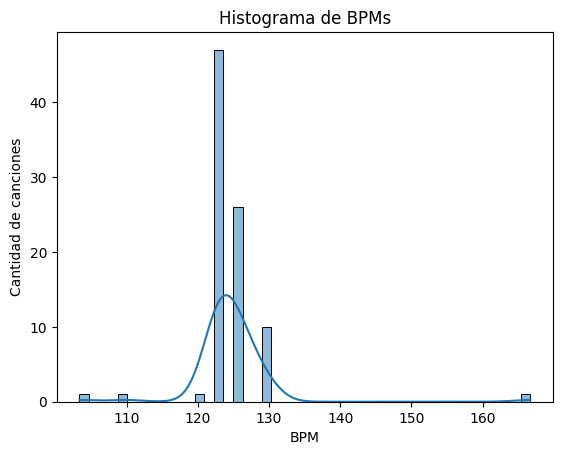

In [97]:
dataset[dataset["bpm"] < 100] *= 2

ax = sns.histplot(dataset["bpm"], kde=True)
ax.set_title("Histograma de BPMs")
ax.set_xlabel("BPM")
ax.set_ylabel("Cantidad de canciones")
plt.show()

In [119]:
dataset = dataset[dataset.bpm < 150]

In [120]:
dataset.describe()

,bpm,spectral_centroid,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,spectral_bandwidth,spectral_contrast_mean,zero_crossing_rate,rms,spectral_rolloff
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,...,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,124.255177,3736.073026,-151.821869,97.107376,-4.443719,50.743881,-7.403452,28.979305,-0.878661,16.066217,...,0.585842,0.581614,0.609099,0.614489,0.625562,3904.738249,21.001930,0.077382,0.258353,7742.290684
std,3.521812,886.926859,47.266945,24.164572,15.313993,15.819285,8.826227,8.891004,5.548856,5.525294,...,0.121160,0.116464,0.123462,0.131261,0.146630,639.865243,3.112434,0.024908,0.055197,1737.854487
min,103.359375,2111.485107,-414.600891,53.622150,-40.058823,24.922709,-29.395840,9.153094,-13.153058,4.922986,...,0.381985,0.416292,0.369858,0.396380,0.391731,2795.652061,16.763500,0.034851,0.123415,4110.335446
25%,123.046875,3105.484576,-168.432461,79.969738,-15.290992,41.666533,-13.482599,23.756428,-4.159264,12.514273,...,0.529067,0.527924,0.547291,0.551263,0.561405,3541.200225,20.209310,0.059352,0.231033,6686.269699
50%,123.046875,3674.882652,-151.094215,97.912983,-6.404517,47.111458,-8.108320,27.073569,-0.965049,15.917956,...,0.570253,0.564614,0.586895,0.605691,0.615028,3830.534156,20.627600,0.077977,0.252728,7672.908938
75%,126.048018,4084.443285,-128.593475,109.726114,6.883168,58.942722,0.079903,33.958470,2.625861,19.891854,...,0.625050,0.613210,0.636123,0.659745,0.668072,4155.627164,21.140038,0.091478,0.277706,8715.774382
max,129.199219,8239.591309,-53.725918,216.423630,45.587330,125.076271,16.684059,70.494316,12.430053,36.348495,...,1.319954,1.332663,1.312562,1.361975,1.551688,7575.659216,40.814323,0.174467,0.522942,16162.829303


<Axes: xlabel='mfcc_3', ylabel='mfcc_5'>

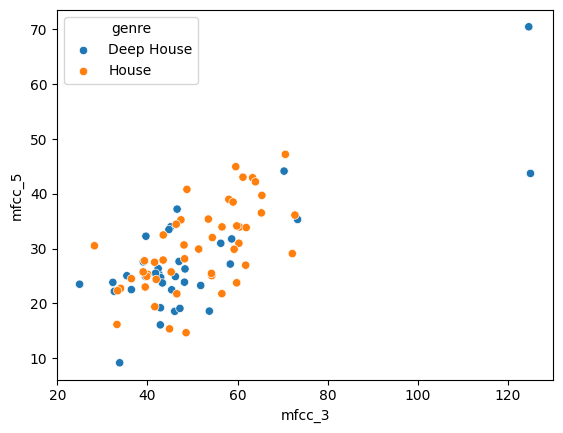

In [122]:
sns.scatterplot(x=dataset.mfcc_3, y=dataset.mfcc_5, hue=dataset.genre)

<Axes: xlabel='spectral_centroid', ylabel='spectral_bandwidth'>

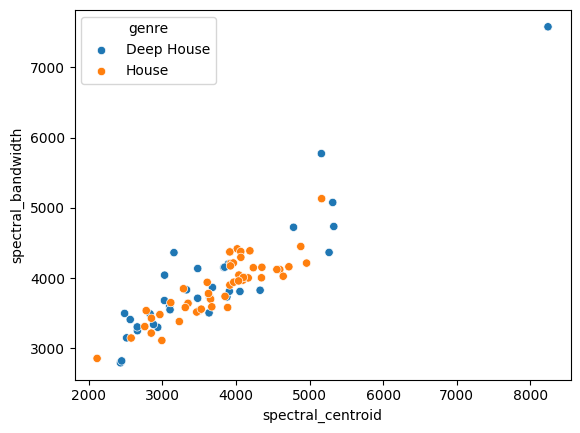

In [125]:
sns.scatterplot(x=dataset.spectral_centroid, y=dataset.spectral_bandwidth, hue=dataset.genre)

In [140]:
def get_column_with_greatest_difference_between_genres():
    columns = set(dataset.columns) - {"track"}
    genres = dataset.genre.unique()
    
    max_dif = 0
    max_dif_col = None

    for column in columns:
        M = {}
        dif = 0.

        for genre1 in genres:
            if genre1 not in M.keys():
                M[genre1] = dataset[dataset.genre==genre1][column].mean()
            
            for genre2 in genres:
                if genre2 not in M.keys():
                    M[genre2] = dataset[dataset.genre == genre2][column].mean()

                dif += abs(M[genre1]-M[genre2])

        if dif > max_dif:
            max_dif = dif
            max_dif_col = column

    return max_dif_col, max_dif

SyntaxError: incomplete input (2044154871.py, line 6)